In [29]:
import pandas as pd
import os
import pydicom
from PIL import Image
import numpy as np

In [30]:
df_concat = pd.read_csv("/kaggle/input/dataframes/df_concat.csv")
df_unlabeled = pd.read_csv("/kaggle/input/dataframes/unannotated_images_info.csv")

df_concat = df_concat.drop(columns=['original_dcm_path'])

# Update the image paths
df_concat['image_path'] = df_concat['image_path'].str.replace(
    '/kaggle/working/missing/', '/kaggle/input/dataframes/missing_folder/', 
    regex=False
)

# Print the DataFrame after the change
print("\nAfter update:")
df_concat.sample()

/tmp/ipykernel_34/304272151.py:1: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  df_concat = pd.read_csv("/kaggle/input/dataframes/df_concat.csv")



After update:


,study_id,series_id,instance_number,condition,level,x,y,image_path,severity
56918,3087715413,1787727285,21,Left Subarticular Stenosis,L2/L3,288.565962,258.239067,/kaggle/input/dataframes/missing_folder/308771...,Normal/Mild


In [31]:
import pandas as pd
from sklearn.utils import resample

# Sample DataFrame setup (replace this with your actual DataFrame)
# df_concat = pd.read_csv('your_data.csv')  # Uncomment if loading from a file

# 1. Drop rows with NaN in 'severity'
df_concat = df_concat.dropna(subset=['severity'])

# 2. Determine the maximum class count
class_counts = df_concat['severity'].value_counts()
max_count = class_counts.max()

print("Class distribution before resampling:")
print(class_counts)

# 3. Prepare a list to hold the resampled data
df_resampled_list = []

# 4. Resample each class to match the maximum count
for cls in class_counts.index:
    # Get all rows of the current class
    class_df = df_concat[df_concat['severity'] == cls]
    
    # Resample the class to match the maximum count
    class_oversampled = resample(class_df,
                                 replace=True,  # Sample with replacement
                                 n_samples=max_count,  # Match the maximum class size
                                 random_state=42)  # For reproducibility
    
    # Append the oversampled class to the list
    df_resampled_list.append(class_oversampled)

# Concatenate all resampled DataFrames
df_resampled = pd.concat(df_resampled_list)

# Shuffle the DataFrame to mix the order of rows
df_resampled = df_resampled.sample(frac=1, random_state=42).reset_index(drop=True)

print("Class distribution after resampling:")
print(df_resampled['severity'].value_counts())

Class distribution before resampling:
severity
Normal/Mild    37626
Moderate       23850
Severe          9243
Name: count, dtype: int64
Class distribution after resampling:
severity
Severe         37626
Moderate       37626
Normal/Mild    37626
Name: count, dtype: int64


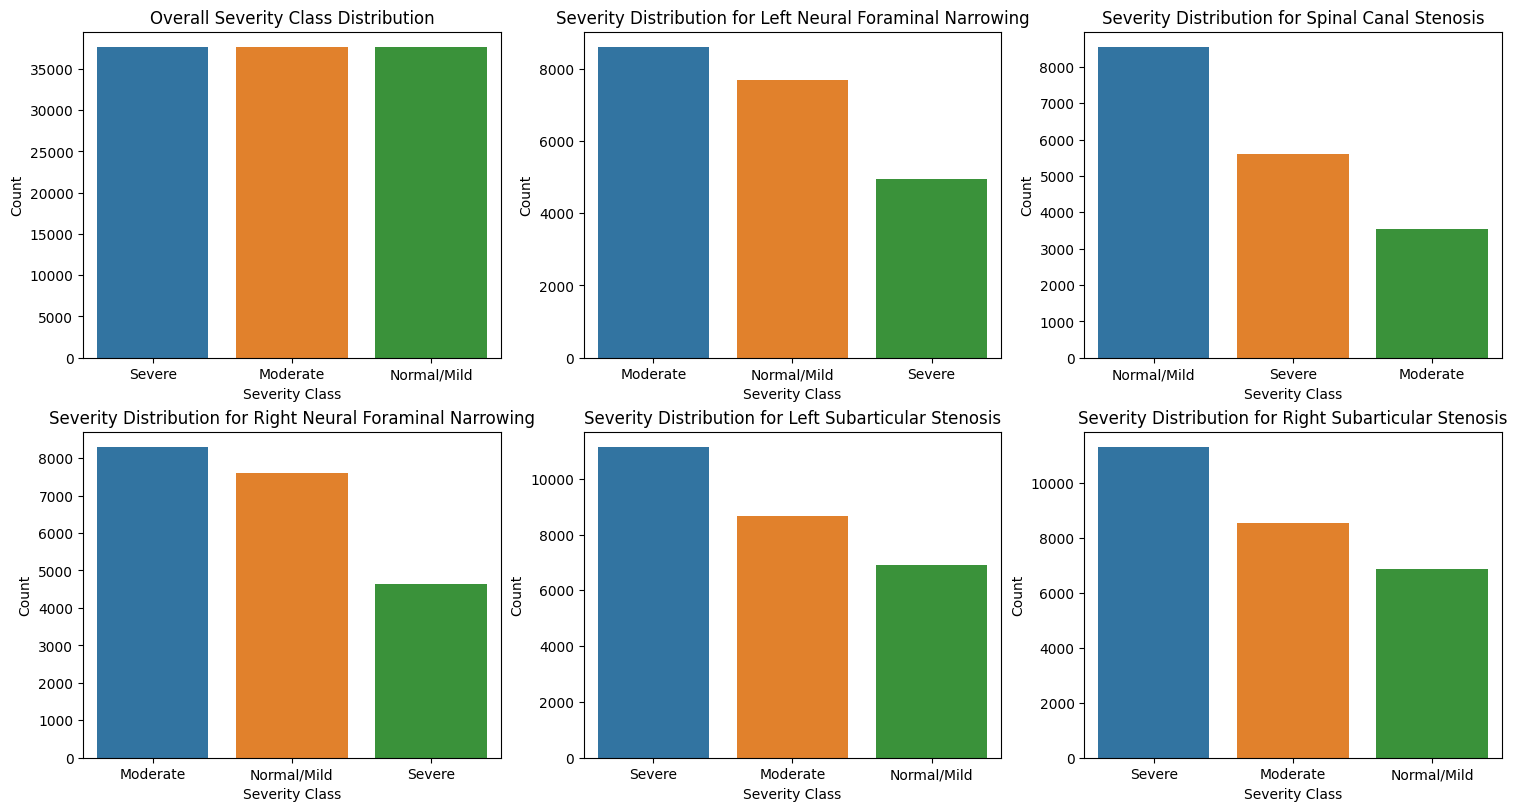

In [32]:
import pandas as pd
from sklearn.utils import resample
import seaborn as sns
import matplotlib.pyplot as plt

# Define the list of conditions to plot
conditions_to_plot = [
    'Left Neural Foraminal Narrowing',
    'Spinal Canal Stenosis',
    'Right Neural Foraminal Narrowing',
    'Left Subarticular Stenosis',
    'Right Subarticular Stenosis'
]

# Create subplots
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 8), constrained_layout=True)

# Plot the overall severity class distribution
sns.countplot(x='severity', data=df_resampled, order=df_resampled['severity'].value_counts().index, ax=axes[0, 0])
axes[0, 0].set_title('Overall Severity Class Distribution')
axes[0, 0].set_xlabel('Severity Class')
axes[0, 0].set_ylabel('Count')

# Plot the severity class distribution for each condition
for i, condition in enumerate(conditions_to_plot):
    row, col = divmod(i + 1, 3)  # Start from the second subplot
    condition_data = df_resampled[df_resampled['condition'] == condition]
    sns.countplot(x='severity', data=condition_data, order=condition_data['severity'].value_counts().index, ax=axes[row, col])
    axes[row, col].set_title(f'Severity Distribution for {condition}')
    axes[row, col].set_xlabel('Severity Class')
    axes[row, col].set_ylabel('Count')

# Remove any empty subplots (if conditions_to_plot length < 5)
for j in range(i + 2, 6):  # Starting from i+2 because i+1 is the last plot created
    row, col = divmod(j, 3)
    fig.delaxes(axes[row, col])

plt.show()

In [33]:
from sklearn.model_selection import train_test_split

# Split data into training and validation sets
train_df, val_df = train_test_split(df_resampled, test_size=0.2, random_state=42, stratify=df_resampled['severity'])

# Optionally split the remaining data into test and validation sets if you want to have a separate test set
# This can be done by splitting val_df further into validation and test sets
val_df, test_df = train_test_split(val_df, test_size=0.5, random_state=42, stratify=val_df['severity'])

In [34]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Create an ImageDataGenerator for training data with augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255  # Only rescaling
)

# Create an ImageDataGenerator for validation and test data (no augmentation, just rescaling)
val_test_datagen = ImageDataGenerator(rescale=1./255)


In [35]:
# Create data generators
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='image_path',
    y_col='severity',
    target_size=(224, 224),
    batch_size=64,
    class_mode='categorical',
    shuffle=True
)

val_generator = val_test_datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col='image_path',
    y_col='severity',
    target_size=(224, 224),
    batch_size=64,
    class_mode='categorical',
    shuffle=False  # No need to shuffle validation data
)

test_generator = val_test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='image_path',
    y_col='severity',
    target_size=(224, 224),
    batch_size=64,
    class_mode='categorical',
    shuffle=False  # No need to shuffle test data
)


Found 21143 validated image filenames belonging to 3 classes.


/opt/conda/lib/python3.10/site-packages/keras/src/legacy/preprocessing/image.py:920: UserWarning: Found 69159 invalid image filename(s) in x_col="image_path". These filename(s) will be ignored.
  warnings.warn(


Found 2625 validated image filenames belonging to 3 classes.


/opt/conda/lib/python3.10/site-packages/keras/src/legacy/preprocessing/image.py:920: UserWarning: Found 8663 invalid image filename(s) in x_col="image_path". These filename(s) will be ignored.
  warnings.warn(


Found 2615 validated image filenames belonging to 3 classes.


/opt/conda/lib/python3.10/site-packages/keras/src/legacy/preprocessing/image.py:920: UserWarning: Found 8673 invalid image filename(s) in x_col="image_path". These filename(s) will be ignored.
  warnings.warn(


In [36]:
# Create an ImageDataGenerator for unlabeled data with augmentation
unlabeled_datagen = ImageDataGenerator(
    rescale=1./255,                # Normalize images
    rotation_range=20,             # Random rotations
    width_shift_range=0.2,         # Random width shifts
    height_shift_range=0.2,        # Random height shifts
    shear_range=0.2,               # Random shearing
    zoom_range=0.2,                # Random zoom
    horizontal_flip=True,          # Random horizontal flip
    fill_mode='nearest'            # Fill mode for new pixels
)

# Create a data generator for the unlabeled data
unlabeled_generator = unlabeled_datagen.flow_from_dataframe(
    dataframe=df_unlabeled,        # DataFrame with image paths (unlabeled)
    x_col='image_path',            # Column with image paths
    target_size=(224, 224),        # Resize images to 224x224
    batch_size=64,                 # Number of images per batch
    class_mode=None,               # No labels for unlabeled data
    shuffle=False                  # No need to shuffle unlabeled data
)


Found 133978 validated image filenames.


In [37]:
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

# Build and compile the model with the adjusted learning rate
model = tf.keras.models.Sequential([
    tf.keras.applications.ResNet50(include_top=False, weights='imagenet', input_shape=(224, 224, 3)),
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(3, activation='softmax')  # Assuming 3 classes
])

# Use the adjusted learning rate
optimizer = Adam(learning_rate=0.001)

model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])


history = model.fit(
    train_generator,                # Training data
    epochs=10,                      # Number of epochs
    validation_data=val_generator,  # Validation data
    validation_split=0.2,           # Fraction of training data to use as validation data (not used here as validation_data is provided)
    shuffle=True,                  # Shuffle training data
    # class_weight={0: 1., 1: 1.5},  # Optional class weights
    #callbacks=[early_stopping, model_checkpoint],  # Callbacks
    verbose=2                      # Verbosity mode
    #teps_per_epoch=100,            # Total steps per epoch (for data generators)
    #validation_steps=50,            # Total steps per validation epoch (for data generators)
    #workers=4,                      # Number of workers for data loading
    #use_multiprocessing=True        # Use multiprocessing for data loading
)

Epoch 1/10


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
W0000 00:00:1723234151.229583      87 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1723234189.857060      88 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1723234292.367881      88 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


331/331 - 215s - 648ms/step - accuracy: 0.5438 - loss: 0.7862 - val_accuracy: 0.4690 - val_loss: 1.1249
Epoch 2/10
331/331 - 131s - 397ms/step - accuracy: 0.5530 - loss: 0.7194 - val_accuracy: 0.4659 - val_loss: 0.9442
Epoch 3/10
331/331 - 133s - 403ms/step - accuracy: 0.5637 - loss: 0.7037 - val_accuracy: 0.4971 - val_loss: 1.0599
Epoch 4/10
331/331 - 133s - 401ms/step - accuracy: 0.5617 - loss: 0.7056 - val_accuracy: 0.5276 - val_loss: 0.7307
Epoch 5/10
331/331 - 132s - 398ms/step - accuracy: 0.5821 - loss: 0.6902 - val_accuracy: 0.5695 - val_loss: 0.7157
Epoch 6/10
331/331 - 132s - 397ms/step - accuracy: 0.6103 - loss: 0.6702 - val_accuracy: 0.5600 - val_loss: 0.9207
Epoch 7/10
331/331 - 133s - 400ms/step - accuracy: 0.6765 - loss: 0.6120 - val_accuracy: 0.6526 - val_loss: 0.6377
Epoch 8/10
331/331 - 133s - 402ms/step - accuracy: 0.7440 - loss: 0.5237 - val_accuracy: 0.7440 - val_loss: 0.5539
Epoch 9/10
331/331 - 132s - 397ms/step - accuracy: 0.8044 - loss: 0.4387 - val_accuracy: 0.

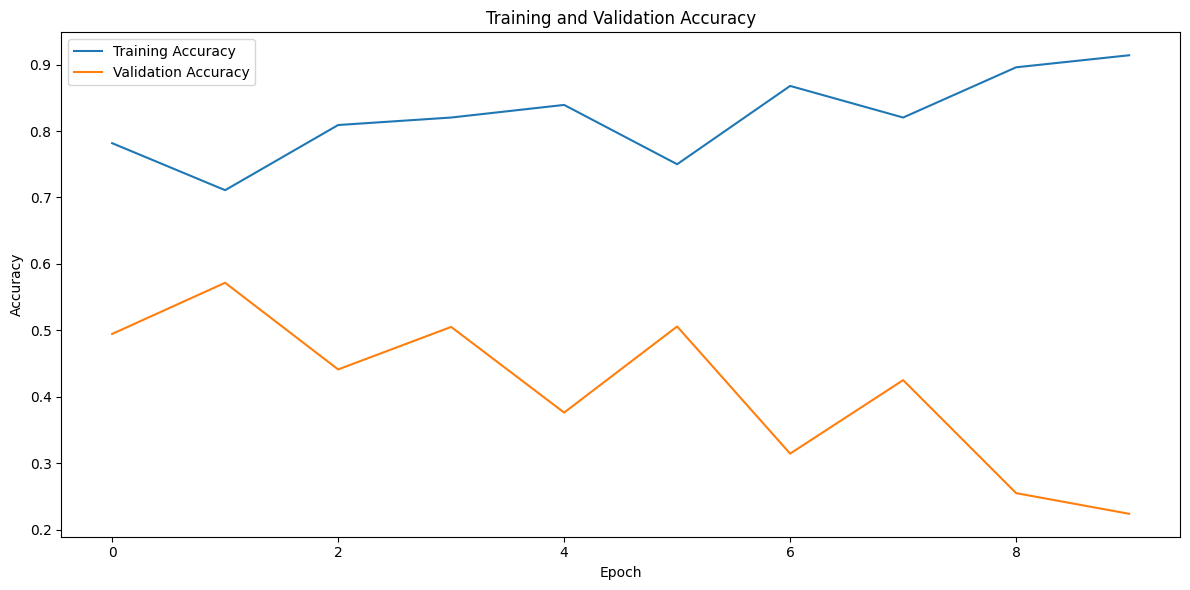

In [83]:
import matplotlib.pyplot as plt

# Assuming 'history' is the variable where you stored the output of model.fit

# Plot Training & Validation Loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['loss'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


In [38]:
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")


41/41 ━━━━━━━━━━━━━━━━━━━━ 16s 383ms/step - accuracy: 0.8319 - loss: 0.4510
Test Loss: 0.457073837518692
Test Accuracy: 0.8237093687057495


W0000 00:00:1723235514.449548      86 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


In [39]:
# Assuming df_unlabeled is your DataFrame containing unlabeled data
df_sampled_unlabeled = df_unlabeled.sample(frac=1.0, random_state=333).reset_index(drop=True)
len(df_sampled_unlabeled)

133978

In [40]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import UnidentifiedImageError

class SafeDataGenerator(tf.keras.utils.Sequence):
    def __init__(self, generator):
        self.generator = generator

    def __len__(self):
        return len(self.generator)

    def __getitem__(self, index):
        while True:
            try:
                batch = self.generator[index]
                return batch
            except UnidentifiedImageError as e:
                print(f"Skipping corrupted image at index {index}: {e}")
                index = (index + 1) % len(self.generator)

# Setup the unlabeled data generator
unlabeled_datagen = ImageDataGenerator(rescale=1./255)

unlabeled_generator = unlabeled_datagen.flow_from_dataframe(
    dataframe=df_sampled_unlabeled,
    x_col='image_path',
    y_col=None,  # No labels
    target_size=(224, 224),
    batch_size=128,
    class_mode=None,  # No labels
    shuffle=False
)

# Wrap the generator with SafeDataGenerator
safe_unlabeled_generator = SafeDataGenerator(unlabeled_generator)


Found 133978 validated image filenames.


In [41]:
# Predict on the sampled unlabeled data
predictions = model.predict(safe_unlabeled_generator)

   2/1047 ━━━━━━━━━━━━━━━━━━━━ 2:18 132ms/step

W0000 00:00:1723235590.550980      87 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 420/1047 ━━━━━━━━━━━━━━━━━━━━ 7:08 683ms/stepSkipping corrupted image at index 420: cannot identify image file <_io.BytesIO object at 0x7d925237e2a0>
1047/1047 ━━━━━━━━━━━━━━━━━━━━ 728s 692ms/step


W0000 00:00:1723236313.945408      87 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


In [42]:
# Extract predicted classes and confidence scores
predicted_classes = np.argmax(predictions, axis=1)
confidence_scores = np.max(predictions, axis=1)

# Filter high-confidence predictions
confidence_threshold = 0.8
high_confidence_mask = confidence_scores >= confidence_threshold

In [43]:
# Create the pseudo-labels DataFrame
pseudo_labels_df = pd.DataFrame({
    'image_path': df_unlabeled['image_path'][high_confidence_mask].values,
    'study_id': df_unlabeled['study_id'][high_confidence_mask].values,
    'series_id': df_unlabeled['series_id'][high_confidence_mask].values,
    'instance_number': pd.NA,  # Assign NaN for missing columns
    'condition': pd.NA,
    'level': pd.NA,
    'x': pd.NA,
    'y': pd.NA,
    'severity': predicted_classes[high_confidence_mask]  # Assign predicted classes as severity
})

# Standardize the DataFrames by matching column names and order
columns_order = ['study_id', 'series_id', 'instance_number', 'condition', 
                 'level', 'x', 'y', 'image_path', 'severity']

pseudo_labels_df = pseudo_labels_df[columns_order]

In [44]:
# Convert severity column to string type
pseudo_labels_df['severity'] = pseudo_labels_df['severity'].astype(str)

# Do the same for the labeled data
train_df['severity'] = train_df['severity'].astype(str)

# Combine the DataFrames
df_combined = pd.concat([train_df, pseudo_labels_df], axis=0).reset_index(drop=True)

# Create the combined data generator
combined_datagen = ImageDataGenerator(rescale=1./255)

combined_train_generator = combined_datagen.flow_from_dataframe(
    dataframe=df_combined,
    x_col='image_path',
    y_col='severity',  # Use severity as the class label
    target_size=(224, 224),
    batch_size=128,
    class_mode='categorical',
    shuffle=True
)


/tmp/ipykernel_34/952065635.py:8: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_combined = pd.concat([train_df, pseudo_labels_df], axis=0).reset_index(drop=True)


Found 93344 validated image filenames belonging to 5 classes.


/opt/conda/lib/python3.10/site-packages/keras/src/legacy/preprocessing/image.py:920: UserWarning: Found 69159 invalid image filename(s) in x_col="image_path". These filename(s) will be ignored.
  warnings.warn(


In [45]:
print("Unique classes in severity column of df_combined:", df_combined['severity'].unique())


Unique classes in severity column of df_combined: ['Normal/Mild' 'Moderate' 'Severe' '0' '2']


In [46]:
# Define a mapping from numeric labels to categorical labels
label_mapping = {
    '0': 'Normal/Mild',  # Map '0' to 'Normal/Mild'
    '1': 'Moderate',  # Map '0' to 'Normal/Mild'
    '2': 'Severe'        # Map '2' to 'Severe'
}

# Apply the mapping to the severity column
df_combined['severity'] = df_combined['severity'].replace(label_mapping)


In [47]:
# Define the valid categories
valid_categories = ['Normal/Mild', 'Moderate', 'Severe']

# Filter the DataFrame to keep only rows with valid categories
df_combined = df_combined[df_combined['severity'].isin(valid_categories)]


In [48]:
combined_datagen = ImageDataGenerator(rescale=1./255)

combined_train_generator = combined_datagen.flow_from_dataframe(
    dataframe=df_combined,
    x_col='image_path',
    y_col='severity',  # Use severity as the class label
    target_size=(224, 224),
    batch_size=128,
    class_mode='categorical',
    shuffle=True
)


Found 93344 validated image filenames belonging to 3 classes.


/opt/conda/lib/python3.10/site-packages/keras/src/legacy/preprocessing/image.py:920: UserWarning: Found 69159 invalid image filename(s) in x_col="image_path". These filename(s) will be ignored.
  warnings.warn(


In [51]:
import os

missing_files = []
for path in df_combined['image_path']:
    if not os.path.exists(path):
        missing_files.append(path)

print(f"Number of missing files: {len(missing_files)}")


Number of missing files: 69159


In [58]:
import os

# Filter out rows where the image path does not exist
df_combined_cleaned = df_combined[df_combined['image_path'].apply(os.path.exists)].reset_index(drop=True)

# Print the number of remaining images
print(f"Number of valid images: {len(df_combined_cleaned)}")

Number of valid images: 93344


In [63]:
df_combined_cleaned.sample()

,study_id,series_id,instance_number,condition,level,x,y,image_path,severity
50990,4128901579,1458017221,<NA>,NaN,NaN,NaN,NaN,/kaggle/input/newdataset1234/train_images_png/...,Normal/Mild


In [64]:
from PIL import Image

# List to store indices of corrupted images
corrupted_indices = []

# Loop through all images and check if they can be opened
for idx, image_path in enumerate(df_combined_cleaned['image_path']):
    try:
        img = Image.open(image_path)
        img.verify()  # Verify that it is, in fact, an image
    except (IOError, SyntaxError) as e:
        corrupted_indices.append(idx)

# Drop corrupted images from the dataframe
df_combined_cleaned = df_combined_cleaned.drop(corrupted_indices).reset_index(drop=True)

print(f"Removed {len(corrupted_indices)} corrupted images.")
print(f"Number of valid images remaining: {len(df_combined_cleaned)}")


Removed 1 corrupted images.
Number of valid images remaining: 93343


In [66]:
# Create the data generator for the cleaned dataset
combined_datagen = ImageDataGenerator(rescale=1./255)

combined_train_generator = combined_datagen.flow_from_dataframe(
    dataframe=df_combined_cleaned,
    x_col='image_path',
    y_col='severity',
    target_size=(224, 224),
    batch_size=128,
    class_mode='categorical',
    shuffle=True
)

# Train the model
history = model.fit(
    combined_train_generator,
    epochs=10,  # Adjust the number of epochs as needed
    steps_per_epoch=combined_train_generator.samples // combined_train_generator.batch_size,
    validation_data=None,  # Add validation data if available
    shuffle=True,
    verbose=1    
)


Found 93343 validated image filenames belonging to 3 classes.
Epoch 1/10


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


729/729 ━━━━━━━━━━━━━━━━━━━━ 524s 712ms/step - accuracy: 0.7908 - loss: 0.4778
Epoch 2/10
729/729 ━━━━━━━━━━━━━━━━━━━━ 1s 26us/step - accuracy: 0.7109 - loss: 0.5716   
Epoch 3/10


/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


729/729 ━━━━━━━━━━━━━━━━━━━━ 530s 720ms/step - accuracy: 0.8197 - loss: 0.4194
Epoch 4/10
729/729 ━━━━━━━━━━━━━━━━━━━━ 1s 27us/step - accuracy: 0.8203 - loss: 0.5051   
Epoch 5/10
729/729 ━━━━━━━━━━━━━━━━━━━━ 525s 713ms/step - accuracy: 0.8519 - loss: 0.3511
Epoch 6/10
729/729 ━━━━━━━━━━━━━━━━━━━━ 1s 28us/step - accuracy: 0.7500 - loss: 0.5057   
Epoch 7/10
729/729 ━━━━━━━━━━━━━━━━━━━━ 525s 713ms/step - accuracy: 0.8782 - loss: 0.2922
Epoch 8/10
729/729 ━━━━━━━━━━━━━━━━━━━━ 1s 28us/step - accuracy: 0.8203 - loss: 0.4249   
Epoch 9/10
729/729 ━━━━━━━━━━━━━━━━━━━━ 524s 711ms/step - accuracy: 0.9075 - loss: 0.2293
Epoch 10/10
729/729 ━━━━━━━━━━━━━━━━━━━━ 1s 27us/step - accuracy: 0.9141 - loss: 0.2237   


In [68]:
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

41/41 ━━━━━━━━━━━━━━━━━━━━ 14s 335ms/step - accuracy: 0.7805 - loss: 0.9005
Test Loss: 0.9277598857879639
Test Accuracy: 0.7705544829368591


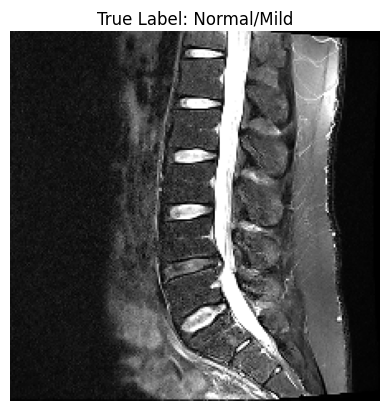

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
Predicted Label: Normal/Mild


In [74]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image

# Select a random batch from the test generator
batch = next(test_generator)
images, labels = batch[0], batch[1]

# Select a random image from this batch
random_index = np.random.randint(0, len(images))
random_image = images[random_index]
true_label = np.argmax(labels[random_index])  # Get the true label for comparison

# Display the image
plt.imshow(random_image)
plt.title(f"True Label: {list(test_generator.class_indices.keys())[true_label]}")
plt.axis('off')  # Hide axes
plt.show()

# Predict the class of this image
# Reshape image for the model
random_image = np.expand_dims(random_image, axis=0)
predictions = model.predict(random_image)
predicted_label = np.argmax(predictions[0])

# Print the predicted label
print(f"Predicted Label: {list(test_generator.class_indices.keys())[predicted_label]}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


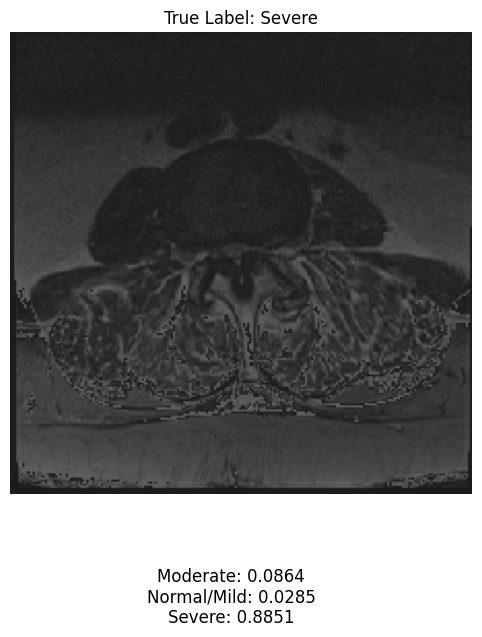

Predicted Label: Severe


In [79]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image

# Select a random batch from the test generator
batch = next(test_generator)
images, labels = batch[0], batch[1]

# Select a random image from this batch
random_index = np.random.randint(0, len(images))
random_image = images[random_index]
true_label = np.argmax(labels[random_index])  # Get the true label for comparison

# Predict the class of this image
# Reshape image for the model
random_image = np.expand_dims(random_image, axis=0)
predictions = model.predict(random_image)
predicted_probs = predictions[0]  # Get the probabilities for each class

# Plot the image
plt.figure(figsize=(8, 6))
plt.imshow(random_image[0])  # Display the image
plt.title(f"True Label: {list(test_generator.class_indices.keys())[true_label]}")
plt.axis('off')  # Hide axes

# Add a text box with predicted probabilities below the image
class_labels = list(test_generator.class_indices.keys())
prob_text = "\n".join([f"{label}: {prob:.4f}" for label, prob in zip(class_labels, predicted_probs)])

plt.figtext(0.5, -0.1, prob_text, wrap=True, horizontalalignment='center', fontsize=12)
plt.show()

# Print the predicted label
predicted_label = np.argmax(predictions[0])
print(f"Predicted Label: {class_labels[predicted_label]}")
